<a href="https://colab.research.google.com/github/Renato89/rain-in-australia/blob/main/RainInAustralia%5Bcon_ETL_e_SARIMA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Piogge in Australia
In questo notebook si tenta di realizzare un modello univariato per predire la quantità di pioggia il giorno dopo. 

I dati sono acquisiti da Kaggle ([Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)). Contengo circa 10 anni di osservazioni giornaliere in diverse località dell'Australia.

Si inizia con l'analisi dei dati per eseguire un'accurata pulizia dei dati. Dopo di che si passa alla costruzione di un modello ARIMA per le predizioni.

## Preparazione dell'ambiente di sviluppo

In [7]:
%%capture
!pip install geopandas

In [8]:
!git clone https://github.com/Renato89/rain-in-australia.git

fatal: destination path 'rain-in-australia' already exists and is not an empty directory.


In [37]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import math
import missingno
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import re
import geopandas
import folium
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from numpy import log
from statsmodels.tsa.arima_model import ARIMA

from google.colab import drive

# Esplorazione dei dati

In [10]:
df = pd.read_csv('rain-in-australia/data/weatherAUS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [11]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Un' oservazione al giorno per un periodo di quasi dieci anni, raggruppati per località. 

Il seguente listato recupera le informazioni geografiche per ognuna delle località e le visualizza su una mappa.
La libreria usata si chiama geopandas e si basa sui DataFrame di pandas ma con l'aggiunta di un campo che contiene informazioni geometriche del record.
Inoltre, si sfrutta la libreria folium per visualizzare le località su una mappa interattiva.

In [12]:
app = Nominatim(user_agent="renato")

lat = []
lon = []
loc = []
not_found = []
for loc_name in df['Location'].unique():
    formatted = re.sub("([a-z])([A-Z])","\g<1> \g<2>", loc_name)
    display_name = formatted + ', Australia'
    location = app.geocode(display_name)
    if location != None:
        lat.append(location.raw['lat'])
        lon.append(location.raw['lon'])
        loc.append(loc_name)
    else:
        not_found.append(loc_name)

d = {'Location':loc, 'Latitude':lat, 'Longitude':lon}
geolocations = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(
    geolocations, 
    geometry=geopandas.points_from_xy(geolocations.Longitude, geolocations.Latitude))

print("Località non trovate: ", len(not_found))

Località non trovate:  0


In [13]:
m = folium.Map(location=[-23, 133], zoom_start=4.4, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    lat = r['geometry'].y
    lon = r['geometry'].x
    folium.Marker(location=[lat, lon],
                  popup='{} <br> lat: {} <br> lon: {}'.format(r['Location'], lat, lon)).add_to(m)

m

#Pulizia dei dati

Il primo problema da affrontare è conoscere la quantità dei dati mancanti. Per avere un'idea chiara si possono sfruttare strumenti di visualizzazione come ciò che mette a disposizione la libreria missingno. Questa mostra in una matrice grafica la distribuzione dei valori nulli di tutte le colonne.

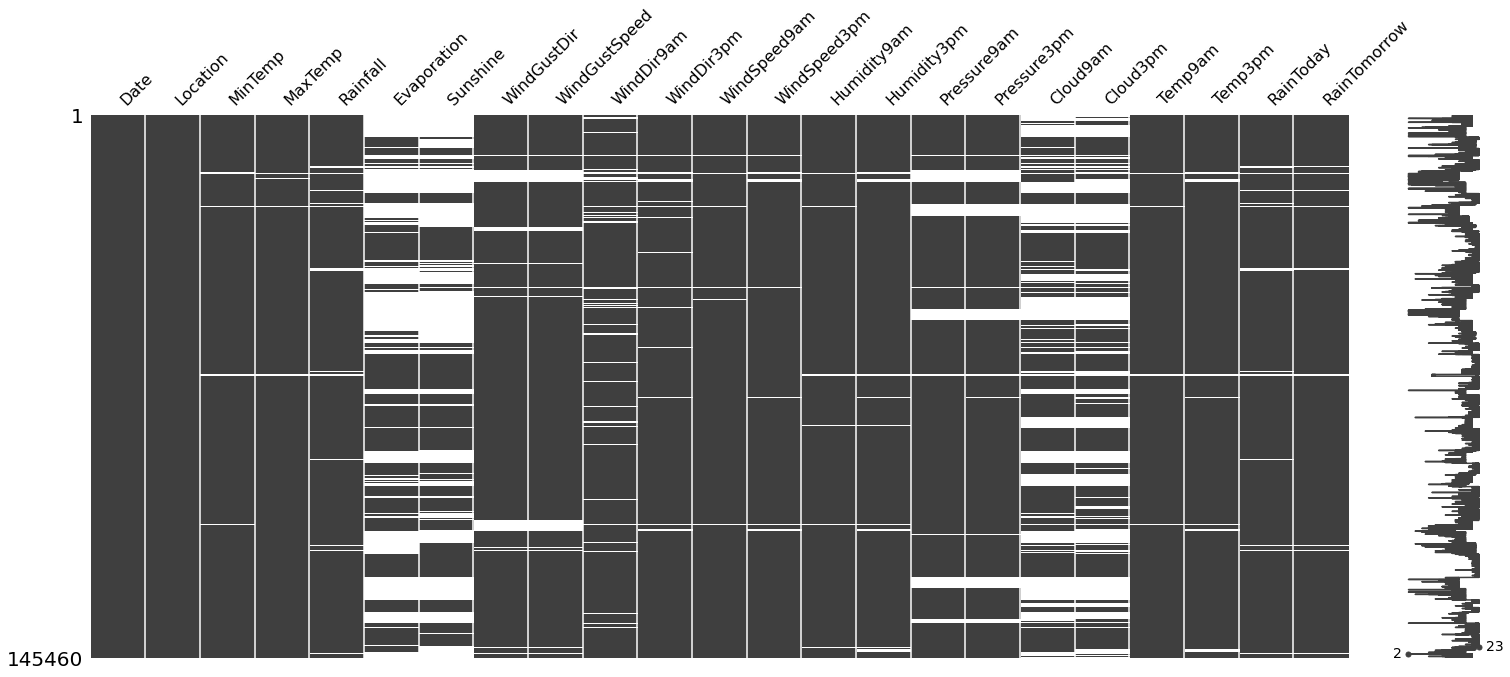

In [14]:
if df.isnull().any(axis=None):
    missingno.matrix(df)

Per avere un'idea di massima si può visualizzare l'istogramma che mostra il conteggio delle osservazioni per ogni giorno.

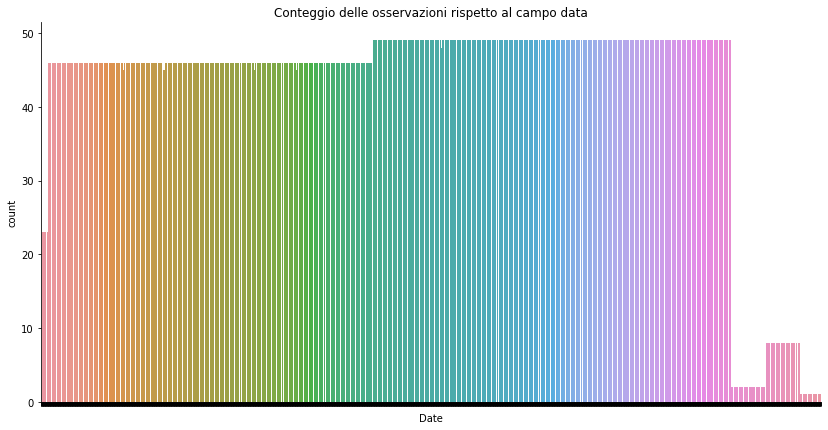

In [15]:
fig = sns.catplot(x='Date', kind='count', data=df, height=6, aspect=2)
fig.set(xticklabels=[], title='Conteggio delle osservazioni rispetto al campo data')

Il grafico mostra il conteggio delle osservazioni per ogni campo data della tabella. Infatti, per lo stesso giorno, abbiamo l'osservazioni di diverse stazioni meteorologiche dislocate in 49 città.
Si nota dal grafico come un porzione iniziale ed una buona fetta nella parte finale del periodo di osservazione, soffrano di mancanza dati. Inoltre, si può vedere che circa la metà della serie abbia una porzione piccola di località che possiede poche osservazioni. Si intervine su questi due aspetti per "ritagliarsi" un porzione contiugua della serie che possieda una bassa percentuale di valori nulli.



## Rimozione di record non validi
Da queste informazioni, possiamo scegliere di individuare ed escludere quelle località e quei periodi dal dataset in modo da avere un notevole miglioramento nella qualità dei dati.

Iniziamo col tagliare via le date all'inizio ed alla fine del periodo di osservazione che possiedono pochissime osservazioni. Si può vedere che queste hanno un conteggio inferiore a 30. Queste, trovandosi all'estremità del periodo, non inficierà sul modello della serie.

In [16]:
valid_records = df['Date'].value_counts() > 30
filter = [ valid_records[x]  for x in df['Date']]

truncated_df = df[filter]

print("Numero di osservazioni rimosse: ", len(df) - len(truncated_df))

Numero di osservazioni rimosse:  2331


A questo punto cerchiamo le località che hanno mancanza di dati.

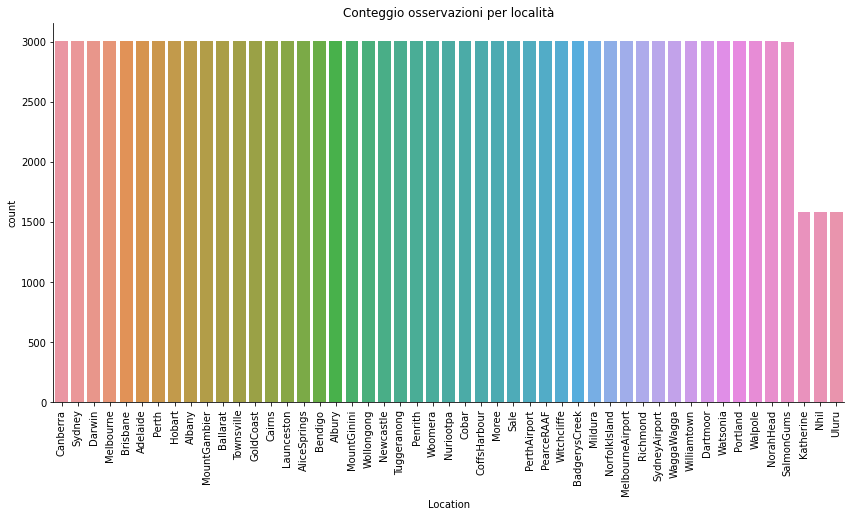

In [17]:
fig = sns.catplot(x='Location', kind='count', data=truncated_df, height=6, aspect=2, order=df['Location'].value_counts().index)
fig.set_xticklabels(rotation=90)
fig.set(title='Conteggio osservazioni per località')

Tre località possiedo metà dei dati rispetto alle altre 46. Queste sono: Katherine, Nhil e Uluru. Decidiamo di eliminarle. Eliminandole, le escludiamo dal modello predittivo, possiamo farlo perchè abbiamo a disposizione una serie temporale per ogni località, quindi, ne abbiamo a disposizione ancora 46.


In [18]:
filtered_df = truncated_df[(truncated_df['Location'] != 'Katherine' ) & 
                           (truncated_df['Location'] != 'Nhil' ) & 
                           (truncated_df['Location'] != 'Uluru' )]
print("Numero di osservazioni rimosse: ", len(truncated_df) - len(filtered_df))

Numero di osservazioni rimosse:  4734


Verifichiamo se il "ritaglio" è andato a buon fine.

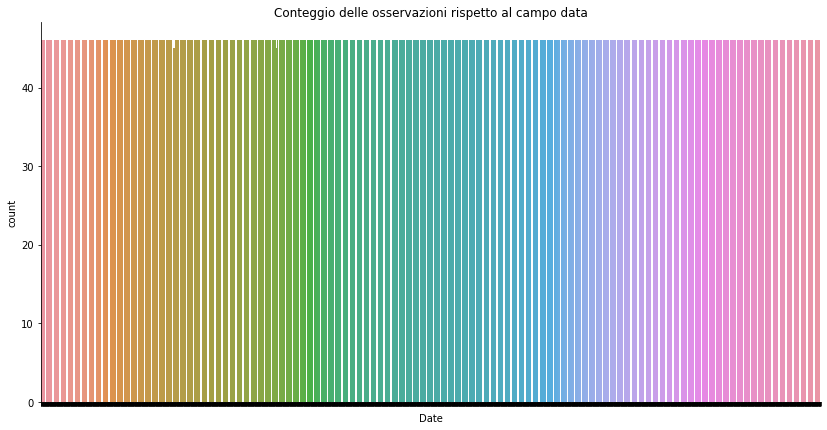

In [19]:
fig = sns.catplot(x='Date', kind='count', data=filtered_df, height=6, aspect=2)
fig.set(xticklabels=[], title='Conteggio delle osservazioni rispetto al campo data')

# Predizione Univariata 
Si vuole prevedere l'arrivo della pioggia. Estraiamo la colonna in esame, 'RainFall' e eseguiamo la procedura per ottenere un modello SARIMA dalla serie. 


In [20]:
rainfall_df = filtered_df[['Date','Location','Rainfall']]
print(rainfall_df)

              Date Location  Rainfall
31      2009-01-01   Albury       0.0
32      2009-01-02   Albury       0.0
33      2009-01-03   Albury       0.0
34      2009-01-04   Albury       0.0
35      2009-01-05   Albury       0.0
...            ...      ...       ...
142299  2017-06-21   Darwin       0.0
142300  2017-06-22   Darwin       0.0
142301  2017-06-23   Darwin       0.0
142302  2017-06-24   Darwin       0.0
142303  2017-06-25   Darwin       0.0

[138395 rows x 3 columns]


## Imputazione
Avendo a disposizione molte località da cui sono state prese le misure, se una località possiede un valore nullo, con buona probabilità il valore catturato da una stazione vicina non è nullo e vicino a quello che sarebbe stato il valore reale.
Quindi, si riordina la serie per data, in modo tale da avere vicini le osservazioni dello stesso giorno, e poi si esegue un'imputazione semplice, assegnando il valore più vicino valido quando si incontra un dato mancante.

In [21]:
rainfall_sorted = rainfall_df.sort_values(by='Date')
print(rainfall_sorted)

              Date      Location  Rainfall
31      2009-01-01        Albury       0.0
18115   2009-01-01     NorahHead       0.0
96504   2009-01-01      Adelaide       0.0
139295  2009-01-01        Darwin       2.4
99544   2009-01-01  MountGambier       0.8
...            ...           ...       ...
49022   2017-06-25      Canberra       0.0
45586   2017-06-25    Wollongong       0.0
93279   2017-06-25     GoldCoast       0.0
64190   2017-06-25          Sale       0.0
142303  2017-06-25        Darwin       0.0

[138395 rows x 3 columns]


In [22]:
last = 0.0
imputed_vals = []
for _, r in rainfall_sorted.iterrows():
    current = r['Rainfall']

    if pd.isnull(current):
        imputed_vals.append(last)
    else:
        imputed_vals.append(current)
        last = current

d = {'Date': rainfall_sorted['Date'],
     'Location': rainfall_sorted['Location'], 
     'Rainfall': imputed_vals}
imputed_rainfall = pd.DataFrame(data=d).sort_values(by='Location')

Si ricontrolla sei i valori nulli sono stati rimossi.

In [23]:
before = (rainfall_df.isnull().mean()*100).rename('Prima')
after = (imputed_rainfall.isnull().mean()*100).rename('Dopo')

null_count = before.to_frame().merge(after.rename('Dopo'), left_index=True, right_index=True)
print(null_count)

             Prima  Dopo
Date      0.000000   0.0
Location  0.000000   0.0
Rainfall  2.278261   0.0


## Date mancanti
Nonostante i valori nulli non siano più presenti può sempre essere presente il problema di date mancanti. Per effettuare le predizioni è necessario che ogni riga rappresenti lo stesso intervallo di tempo, nel nostro caso un giorno. Quindi, si esegue la seguente procedura:


1.   si individua l'intervallo temporale della serie
2.   si genera una lista di indici temporali con frequenza giornaliera
3.   la si confronta con quella del dataset e, se non corrisponde,
4.   si espande la serie temporale con le dati mancanti aggiungendo dei valori 
nulli
5.   si estraggono gli stessi periodi mancanti ma dell'anno precedente e,
6.   si sostituiscono con essi.


In [24]:
location = 'Melbourne'
filtered = imputed_rainfall.query('Location == @location')
rainfall_series = filtered['Rainfall']
rainfall_series.index = pd.to_datetime(filtered['Date'])
rainfall_series.sort_index()

Date
2009-01-01    0.0
2009-01-02    0.2
2009-01-03    0.6
2009-01-04    0.0
2009-01-05    0.0
             ... 
2017-06-21    0.6
2017-06-22    0.2
2017-06-23    0.0
2017-06-24    1.4
2017-06-25    0.0
Name: Rainfall, Length: 3009, dtype: float64

In [25]:
first_day = rainfall_series.index.min()
last_day = rainfall_series.index.max()
print("Finestra temporale da", first_day, " a ", last_day) 

Finestra temporale da 2009-01-01 00:00:00  a  2017-06-25 00:00:00


In [26]:
correct_index = pd.period_range(first_day, last_day, freq = 'D')
actual_index = rainfall_series.index.to_period(freq = 'D')
print("Numero di giorni del periodo: ", len(correct_index))
print("Numero di record nei dati: ", len(actual_index))

Numero di giorni del periodo:  3098
Numero di record nei dati:  3009


In [27]:
rainfall_series.index = actual_index
expanded_df = rainfall_series.reindex(correct_index).to_frame()

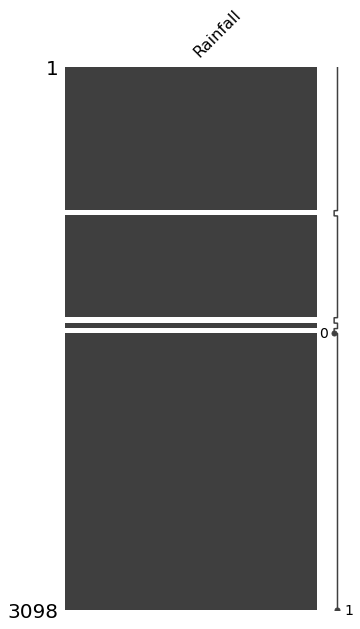

In [28]:
missingno.matrix(expanded_df, figsize=(5,10))

Come si può vedere, i vuoti nelle date si concentrano i tre punti. In realtà, se si va nel dettaglio, si troverà che tale date corrispondono a precisamente tre mesi.


In [29]:
# Estrai gli intervalli di tempo mancanti 

null_intervals = []
counting = False
series = expanded_df['Rainfall']
first = series.index[0]
last = first
for idx, x in series.iteritems():

    if math.isnan(x) and not counting:
        first = idx
        counting = True
    
    if not math.isnan(x) and counting:
        last = idx - 1
        counting = False
        null_intervals.append(pd.period_range(first,last))

print("Intervalli temporali: \n", null_intervals)

Intervalli temporali: 
 [PeriodIndex(['2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04',
             '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-08',
             '2011-04-09', '2011-04-10', '2011-04-11', '2011-04-12',
             '2011-04-13', '2011-04-14', '2011-04-15', '2011-04-16',
             '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20',
             '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24',
             '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28',
             '2011-04-29', '2011-04-30'],
            dtype='period[D]'), PeriodIndex(['2012-12-01', '2012-12-02', '2012-12-03', '2012-12-04',
             '2012-12-05', '2012-12-06', '2012-12-07', '2012-12-08',
             '2012-12-09', '2012-12-10', '2012-12-11', '2012-12-12',
             '2012-12-13', '2012-12-14', '2012-12-15', '2012-12-16',
             '2012-12-17', '2012-12-18', '2012-12-19', '2012-12-20',
             '2012-12-21', '2012-12-22', '2012-12-23', '2012-12-24',
    

In [30]:
# Sostituisci il periodo mancante con lo stesso periodo dell'anno precedente

for p in null_intervals:
    start_day = p[0].day
    start_month = p[0].month
    start_year = p[0].year - 1 # anno precedente

    end_day = p[-1].day
    end_month = p[-1].month
    end_year = p[-1].year - 1 # anno precedente

    prev_year_start = pd.Period(year=start_year, month=start_month, day=start_day, freq='D')
    prev_year_end = pd.Period(year=end_year, month=end_month, day=end_day, freq='D')

    prev_year = pd.period_range(prev_year_start, prev_year_end)

    # sostituisci
    series.loc[p] = series.loc[prev_year].array 

In [31]:
print("Valori null dopo la modifica: ", series.isnull().mean()*100)

Valori null dopo la modifica:  0.0


# Il modello
Si sceglie il modello SARIMA. Prendiamo una località, per esempio Sydney e verifichiamo la stazionarietà della serie.

## Scelta del parametro di differenziazione


In [32]:
data = series.to_frame().sort_index()
data['D.Rainfall'] = data['Rainfall'].diff()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f200ef48f50>,
      dtype=object)

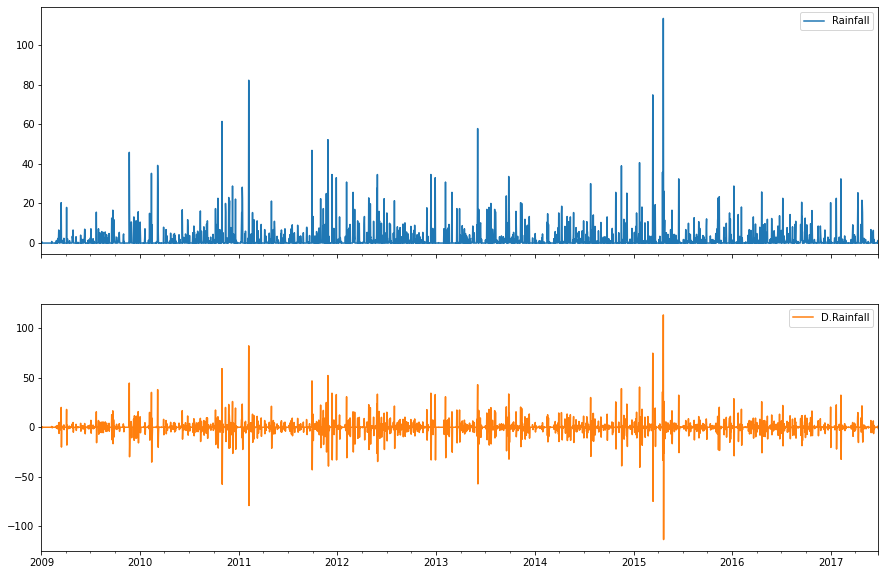

In [33]:
data.plot(kind='line',subplots=True, figsize=(15,10))

In [34]:
pv = adfuller(data['Rainfall'])[1]
print('p-value: %f' % pv)

p-value: 0.000000


Visto che il test di Fuller risulta con un p-value zero, significa che la serie è già stazionaria e non necessita di differenziazione.


## Scelta del parametro di media mobile (MA)


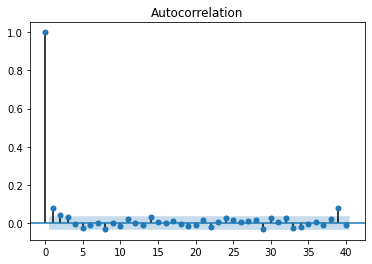

In [35]:
sm.graphics.tsa.plot_acf(data['Rainfall'].values.squeeze(), lags=40)
plt.show()

Il numero dei primi punti che si trovano al di fuori dell'area di confidenza, indica il numero di termini necessari per rimuovere l'autocorrelazione dalla serie stazionaria.

In questo caso scegliamo un valore di autoregressione (MA) di 1.

## Scelta del parametro di autoregressione (AR)
Si ispeziona i termini precedenti senza considerari quelli nel mezzo.

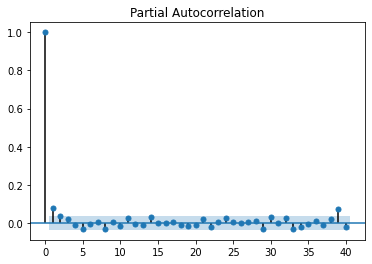

In [36]:
sm.graphics.tsa.plot_pacf(data['Rainfall'].values.squeeze(), lags=40, method="ywm")
plt.show()

Si sceglie p=1.

Scomporre il dataset.

In [ ]:
# TODO cpntinuare da qui, il df pronto si trova in data

In [44]:
data["Rainfall"].values

array([0. , 0.2, 0.6, ..., 0. , 1.4, 0. ])

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3098
Model:                     ARMA(1, 1)   Log Likelihood               -9805.912
Method:                       css-mle   S.D. of innovations              5.733
Date:                Mon, 21 Mar 2022   AIC                          19619.824
Time:                        17:06:08   BIC                          19643.978
Sample:                             0   HQIC                         19628.498
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9627      0.118     16.628      0.000       1.731       2.194
ar.L1.y        0.4589      0.134      3.426      0.001       0.196       0.721
ma.L1.y       -0.3799      0.139     -2.732      0.0

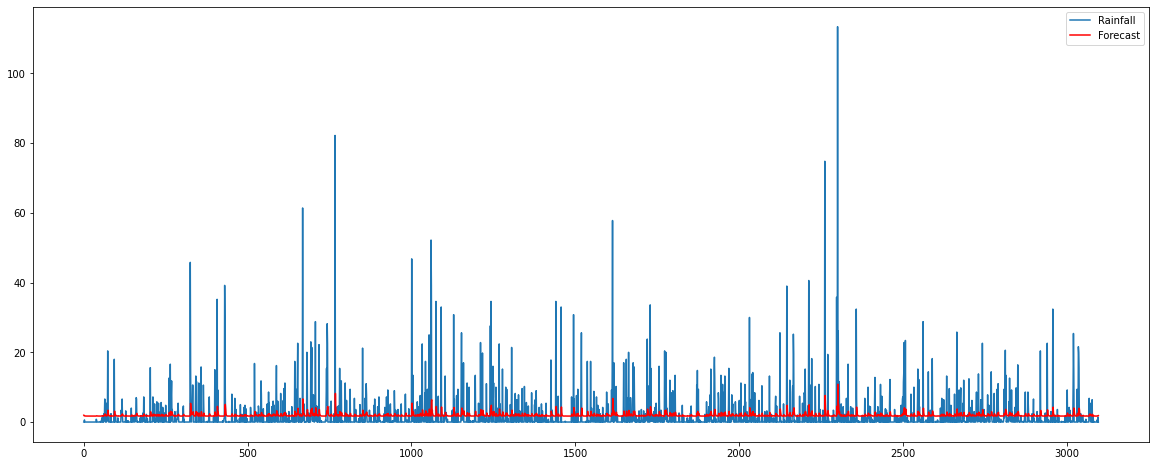

In [46]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(data['Rainfall'].values, order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data['Rainfall'].values)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Rainfall', 'Forecast'])

print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3098
Model:                     ARMA(2, 2)   Log Likelihood               -9804.336
Method:                       css-mle   S.D. of innovations              5.730
Date:                Mon, 21 Mar 2022   AIC                          19620.672
Time:                        17:09:42   BIC                          19656.903
Sample:                             0   HQIC                         19633.682
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9630      0.112     17.598      0.000       1.744       2.182
ar.L1.y        1.3930      0.197      7.057      0.000       1.006       1.780
ar.L2.y       -0.6077      0.153     -3.974      0.0

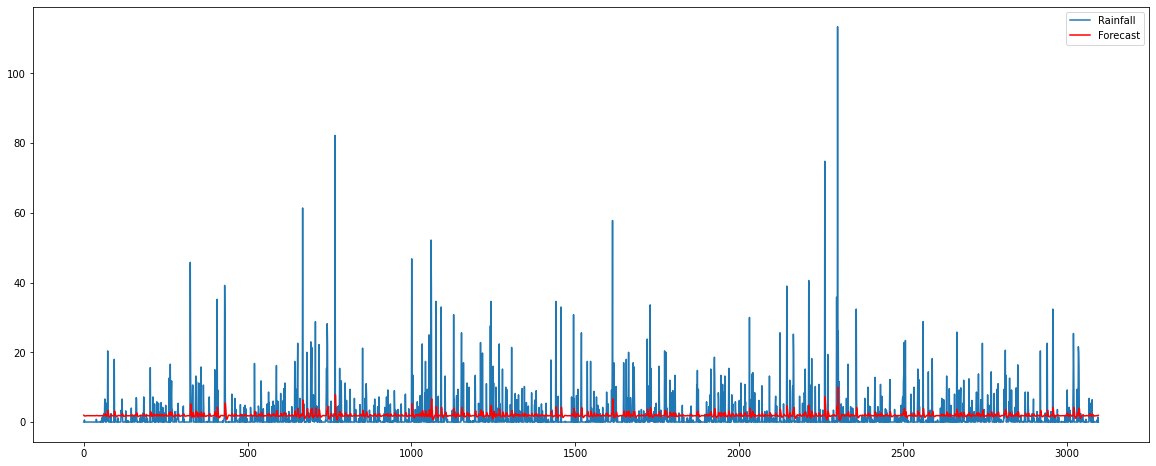

In [54]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(data['Rainfall'].values, order=(2,0,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data['Rainfall'].values)
plt.plot(results.fittedvalues, color='red')
ax.legend(['Rainfall', 'Forecast'])

print(results.summary())

## Predizioni out-of-sample


In [64]:
data['Rainfall'].values[:1200]

array([0. , 0.2, 0.6, ..., 0. , 0. , 0. ])

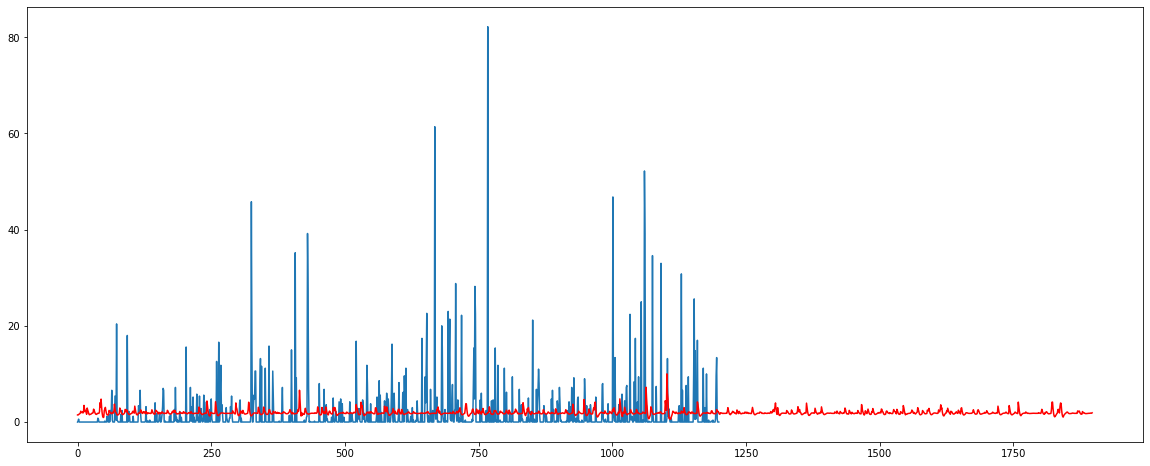

In [69]:
# TODO non riesco ad ottenere il grafico rosso dopo quello blu come ha fatto l'assistente 
# ma si sovrappongono anche se ho usato codice quasi uguale
fig = plt.figure(figsize=(20,8))

x = results.predict(start=(1200), end=(3097), dynamic=False)

plt.plot(data['Rainfall'].values[:1200])
plt.plot(x, color='r')

# Sommario
Tra i due modelli non vi è molta differenza, questo potrebbe stare a significare che, per prevedere la pioggia è necessario qualche informazione in più dello stesso dato nei giorni precedenti. 

Per quanto riguarda la previsione, si nota come alcuni picchi e zone di assenza coincidano, quindi, l'informazione binaria pioggia si / pioggia no riesce a trarla ma manca totalmente della giusta quantità di pioggia.

Probabilmente, sono necessari altri dati come la temperatura e l'umidità, con l'aiuto di modelli multivariati per migliorare i risultati.